In [72]:
from torchvision import datasets, transforms

# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor()
])

# 加载CIFAR10数据集
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super(ConvVAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        # 编码器 - 使用卷积层
        self.encoder = nn.Sequential(
            # 输入: 3x32x32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # 32x16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 64x8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128x4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 256x2x2
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Flatten(),  # 展平为向量
        )
        
        # 计算展平后的维度
        self.encoded_dim = 256 * 2 * 2  # 256个特征图，每个2x2
        
        # 均值和对数方差
        self.fc_mu = nn.Linear(self.encoded_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoded_dim, latent_dim)
        
        # 解码器 - 使用转置卷积
        self.decoder_input = nn.Linear(latent_dim, self.encoded_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 2, 2)),  # 恢复形状
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x4x4
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 64x8x8
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 32x16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 32x16x16
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.2),
            nn.ConvTranspose2d(32, 3, kernel_size=3, padding=1),    # 3x32x32
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h = self.decoder_input(z)
        return self.decoder(h)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [74]:
def vae_loss_function(recon_x, x, mu, logvar):
    """计算VAE的损失函数"""
    # 这里使用MSE
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL散度
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return 2 * MSE + KLD

In [75]:
# 确认一下确实跑在GPU上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device  = "cpu"
print(f'Using device: {device}')

Using device: cuda


In [76]:
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 设置数据加载器
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 初始化模型
input_dim = train_dataset[0][0].numel()  # 28*28=784
hidden_dim = input_dim // 2
latent_dim = 512
model = ConvVAE(latent_dim=latent_dim)

# 定义优化器，使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=3e-4)

model.to(device)

def train_epoch(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)  # 移动到device
        optimizer.zero_grad()                  # 清零梯度，一是pytorch默认累计梯度，二是保证batch独立
        recon_batch, mu, logvar = model(data) # 前向传播
        loss = vae_loss_function(recon_batch, data, mu, logvar)  # 计算损失
        loss.backward()                        # 反向传播
        train_loss += loss.item()              # 累加损失
        optimizer.step()                       # 更新参数
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}')
    return avg_loss

def test_epoch(epoch):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = vae_loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()
    avg_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_loss:.4f}')
    return avg_loss

def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon_batch, _, _ = model(data)
        
        n = 10  # 显示前10张图片
        plt.figure(figsize=(20, 4))
        for i in range(n):
            # 原始图片
            ax = plt.subplot(2, n, i + 1)
            img = data[i].cpu().view(3, 32, 32).permute(1, 2, 0)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # 重构图片
            ax = plt.subplot(2, n, i + 1 + n)
            img = recon_batch[i].cpu().view(3, 32, 32).permute(1, 2, 0)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

def generate_samples(num_samples=10):
    model.eval()
    with torch.no_grad():
        # 从标准正态分布中采样潜在变量
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = model.decode(z).cpu()
        
        plt.figure(figsize=(20, 4))
        for i in range(num_samples):
            ax = plt.subplot(1, num_samples, i + 1)
            img = samples[i].view(3, 32, 32).permute(1, 2, 0)
            plt.imshow(img)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()

def visualize_latent_space():
    model.eval()
    all_z = []
    all_labels = []
    with torch.no_grad():
        for data, labels in test_loader:
            # ---------------------------------------------------------
            # 修改处：不要展平数据 (view)，直接传输到 device
            # 假设 data 的形状是 [batch, channels, height, width]
            # ---------------------------------------------------------
            data = data.to(device)  
            
            # 如果你的模型需要特定的处理，确保这里传入的是 [N, C, H, W] 格式
            mu, logvar = model.encode(data)
            z = model.reparameterize(mu, logvar)
            all_z.append(z.cpu())
            all_labels.append(labels)
    
    all_z = torch.cat(all_z)
    all_labels = torch.cat(all_labels)
    
    # ... 后面的绘图代码保持不变 ...
    if latent_dim == 2:
        z_np = all_z.numpy()
        labels_np = all_labels.numpy()
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_np[:, 0], z_np[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.xlabel('z1')
        plt.ylabel('z2')
        plt.title('2D Latent Space Visualization')
        plt.show()
    else:
        from sklearn.decomposition import PCA
        z_np = all_z.numpy()
        labels_np = all_labels.numpy()

        pca = PCA(n_components=2)
        z_2d = pca.fit_transform(z_np)
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter)
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')
        plt.title('Latent Space Visualization (PCA)')
        plt.show()


Train Epoch: 1 [0/50000 (0%)]	Loss: 831.960876
Train Epoch: 1 [12800/50000 (26%)]	Loss: 210.582352
Train Epoch: 1 [25600/50000 (51%)]	Loss: 199.837067
Train Epoch: 1 [38400/50000 (77%)]	Loss: 185.578979
====> Epoch: 1 Average loss: 219.5153
====> Test set loss: 181.6389
Train Epoch: 2 [0/50000 (0%)]	Loss: 178.167511
Train Epoch: 2 [12800/50000 (26%)]	Loss: 175.089294
Train Epoch: 2 [25600/50000 (51%)]	Loss: 165.860458
Train Epoch: 2 [38400/50000 (77%)]	Loss: 167.880859
====> Epoch: 2 Average loss: 170.6349
====> Test set loss: 158.1291
Train Epoch: 3 [0/50000 (0%)]	Loss: 162.161545
Train Epoch: 3 [12800/50000 (26%)]	Loss: 157.604767
Train Epoch: 3 [25600/50000 (51%)]	Loss: 149.393814
Train Epoch: 3 [38400/50000 (77%)]	Loss: 148.520416
====> Epoch: 3 Average loss: 149.9134
====> Test set loss: 143.7808
Train Epoch: 4 [0/50000 (0%)]	Loss: 141.068649
Train Epoch: 4 [12800/50000 (26%)]	Loss: 135.732422
Train Epoch: 4 [25600/50000 (51%)]	Loss: 138.813965
Train Epoch: 4 [38400/50000 (77%)]	L

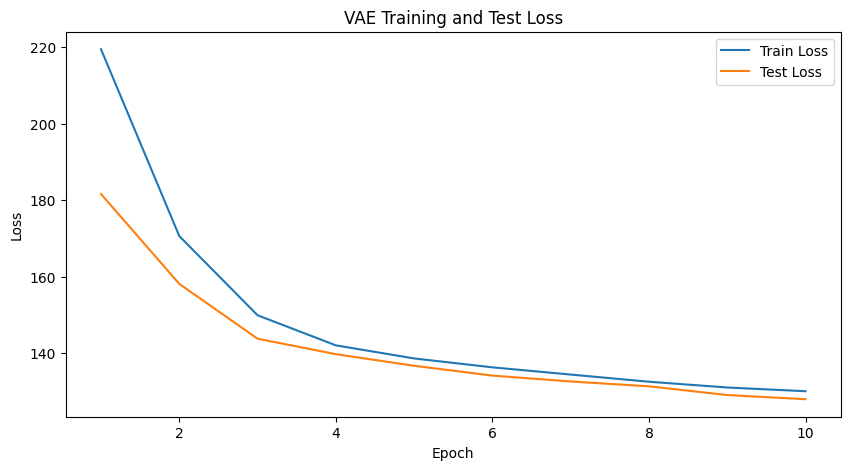

In [77]:
n_epochs = 10
train_losses = []
test_losses = []
for epoch in range(1, 1+n_epochs):
    train_loss = train_epoch(epoch)
    test_loss = test_epoch(epoch)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
# 可视化训练和测试损失
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training and Test Loss')
plt.legend()
plt.show()
torch.save(model.state_dict(), 'vae_mnist_cvae.pth')

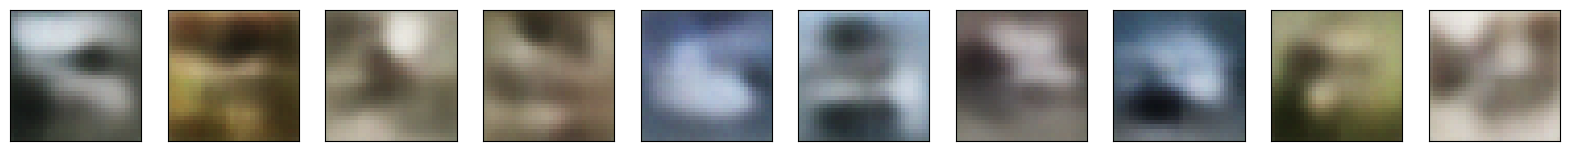

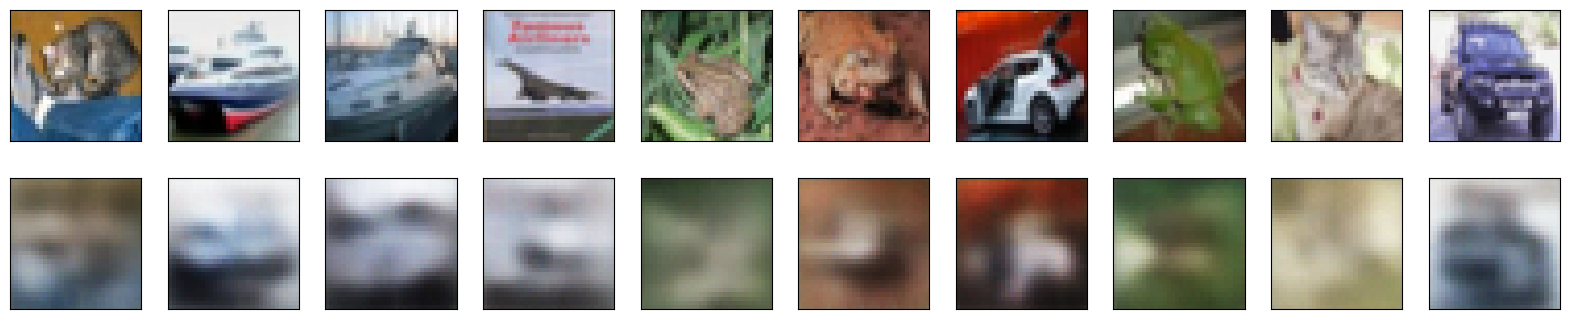

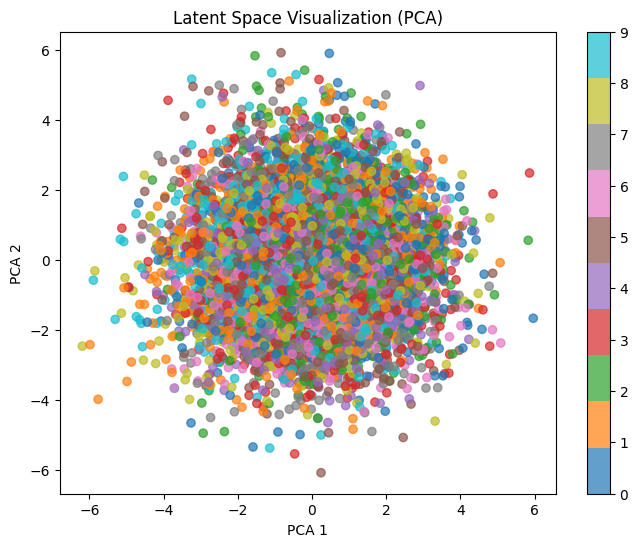

In [78]:
generate_samples(num_samples=10)
visualize_reconstructions()
visualize_latent_space()